**классификатор текстов LSTM на Keras+TensorFlow**

Евгений Борисов <borisov.e@solarl.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm

In [2]:
tqdm.pandas()

/usr/lib/python3.9/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [4]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [5]:
neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [6]:
pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [7]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [8]:
data.sample(10)

,id,ttext,ttype
79040,419429507565895680,"""@Tsemaaa: Скучаю :(( http://t.co/FRdybSnjW4"" походу каждый раз, когда я улетаю в Португалию, я пишу что скучаю по Маше",-1
51063,415192417089110016,"@rodnyansky Вениамин, в России очень много не диагностированных психически больных. Нет смысла даже переживать :(",-1
62480,416826349223809024,"@lesy_zelenina я не смоглаааа, комп отобралии;((",-1
76316,410697247719165952,"Надеюсь я выживу после сегодняшней тренировки, и завтра смогу прийти))",1
77849,419191382205804544,RT @DHO_OKEAHA_: Никто не ревнует\nНикто не любит\nНикто не хочет\nНикто не думает обо мне\nНикто.\nН\nИ\nК\nТ\nО,-1
57422,410123526620717056,"@Ketti_Black ахахаха ну давайте че,мы с лоховскими билетами будем свободно стоять а вы двиться)я за!",1
79556,419470082817802240,"на меня напала жуткая ностальгия,хочу 2012 год,хочу икс фактор :(((",-1
21258,409423130717724672,А мб настал уже тот день?главное завтра проснуться с такими же мыслями),1
10678,409290378047930368,"Ездить на вездеходе по гололеду и в темноте, офигительно!)",1
44851,414379521102843904,"А еще я решила испытать на себе шокер.Зачем,ну зачем я это сделала?:(",-1


## очистка данных

In [9]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 226833/226833 [00:01<00:00, 120575.60it/s]


In [10]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [11]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 226833/226833 [00:02<00:00, 103330.29it/s]


In [12]:
data.sample(3)

,id,ttext,ttype,ttext_clean
113281,411215204715094016,"и кто бы там что ни говорил,все очень приятно,но голос подать я и сама могу. впрочем правда,необычно) спасибо",1,"[и, кто, бы, там, что, ни, говорил, все, очень, приятно, но, голос, подать, я, и, сама, могу, впрочем, правда, необычно, спасибо]"
3724,409050736300150784,"Потрясающее шоу, незабываемое зрелище)\nОгромный объем положительных эмоций и заряда",1,"[потрясающее, шоу, незабываемое, зрелище, огромный, объем, положительных, эмоций, и, заряда]"
90207,421638072728838144,"russianpost.ru - с вечера уже 502 Bad Gateway. =( Он что на выходные все ложат, что бы не обновлять ничего?!..",-1,"[russianpost, ru, с, вечера, уже, digit, bad, gateway, он, что, на, выходные, все, ложат, что, бы, не, обновлять, ничего]"


In [13]:
# удаление коротких слов
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

100%|██████████| 226833/226833 [00:00<00:00, 358162.16it/s]


In [14]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 831


In [15]:
data.sample(3)

,id,ttext,ttype,ttext_clean
61567,410293715631341568,"@zen_pc также, как в консервной банке ;-) у меня 2/3 крыши стекло ;-)",1,"[zen, также, как, консервной, банке, happysmile, меня, digit, digit, крыши, стекло, happysmile]"
124807,410379674666401792,"больше всего мне на линуксе не хватает 3-х вещей: фотошопа, айтюнса и лингво... =(",-1,"[больше, всего, мне, линуксе, хватает, digit, вещей, фотошопа, айтюнса, лингво]"
106175,411144880153309184,"@whatsnextdude да, но в Эстерсунде и Хохфильцене она норм была:) ну впрочем, ладно\nКанадки молодцы, все бы так к олимп. сезону готовились",1,"[whatsnextdude, эстерсунде, хохфильцене, она, норм, была, happysmile, впрочем, ладно, канадки, молодцы, все, так, олимп, сезону, готовились]"


In [32]:
voc = sorted(set.union(*[ set(s) for s in data['ttext_clean'].values.tolist() ]))
voc = { w:i+1 for i,w in enumerate(voc) }
voc['<pad>']= 0
ppr(voc)

записей: 239 518


In [33]:
voc

{'aaa': 1,
 'aaaa': 2,
 'aaaaa': 3,
 'aaaaaaaaaa': 4,
 'aaaaaaaaaaart': 5,
 'aaaaaahhhhhhwow': 6,
 'aaaasyaaa': 7,
 'aaaats': 8,
 'aaahaahaaaah': 9,
 'aaaidar': 10,
 'aaaiguuul': 11,
 'aaakristya': 12,
 'aaalsusha': 13,
 'aaarrrrrrrr': 14,
 'aaaw': 15,
 'aaburnashov': 16,
 'aafrolova': 17,
 'aakarimova': 18,
 'aakellah': 19,
 'aakuzichev': 20,
 'aaleksandra': 21,
 'aaleksandrowna': 22,
 'aalello': 23,
 'aalexithymiaa': 24,
 'aalistok': 25,
 'aalive': 26,
 'aallanavaz': 27,
 'aalove': 28,
 'aammmmmmmm': 29,
 'aamnastya': 30,
 'aamooorr': 31,
 'aamy': 32,
 'aanaokay': 33,
 'aanastasiaden': 34,
 'aandrushkas': 35,
 'aanechaev': 36,
 'aanjkaa': 37,
 'aanneeeet': 38,
 'aannybarry': 39,
 'aanvarova': 40,
 'aanxaa': 41,
 'aapogodina': 42,
 'aarn': 43,
 'aaronpaul': 44,
 'aasexuality': 45,
 'aashirokov': 46,
 'aasokol': 47,
 'aasviridova': 48,
 'aatemkin': 49,
 'aavsasha': 50,
 'aavst': 51,
 'aaw': 52,
 'aaww': 53,
 'aaxaxaax': 54,
 'aayra': 55,
 'aazbaeva': 56,
 'abachurin': 57,
 'abaevart': 

## строим датасет

In [36]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|██████████| 226831/226831 [00:00<00:00, 291387.56it/s]


In [40]:
data[['ttext','ttext_clean','code']].sample(3)

,ttext,ttext_clean,code
154178,"Короче, тупые вы все( Я то тоже, но я хотя бы молчу.","[короче, тупые, все, тоже, хотя, молчу]","[127626, 216879, 89214, 214280, 228440, 141324]"
41542,"Можно сказать, что я был прав. просто характер у меня такой )","[можно, сказать, что, был, прав, просто, характер, меня, такой]","[140952, 199790, 232369, 82115, 178739, 185130, 226500, 138734, 211331]"
217454,"Ну блин. Зашибись. Подготовительная группа по физре! Пздц! Не из-за одного, так из-за другого :(","[блин, зашибись, подготовительная, группа, физре, пздц, одного, так, другого, sadsmile]","[78582, 114839, 170626, 97179, 224130, 167244, 156147, 211256, 104677, 51505]"


In [47]:
data['code'].str.len().describe().astype(int)

count    226831
mean         10
std           3
min           1
25%           7
50%           9
75%          13
max          32
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

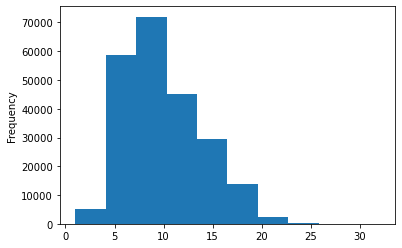

In [45]:
data['code'].str.len().plot.hist()

In [41]:
code_max_len = data['code'].str.len().max()
code_max_len

32

In [49]:
z = [0]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 226831/226831 [00:00<00:00, 668955.24it/s]


In [ ]:
data['code'].str.len().describe().astype(int)

---

In [50]:
x = np.stack( data['code'].values).astype(int)
x.shape

(226831, 32)

In [55]:
x = np.flip(x,axis=1)

In [56]:
n_classes=2
target = data['ttype'].values
target = (target+1)//2
y = np.eye(n_classes)[target]

y.shape

(226831, 2)

In [57]:
max_word = x.max()
seq_len = x.shape[1]
x.shape , y.shape, max_word, seq_len

((226831, 32), (226831, 2), 239517, 32)

In [58]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((136098, 32), (136098, 2), (90733, 32), (90733, 2))

In [59]:
y_train.sum(axis=0),y_test.sum(axis=0),

(array([67275., 68823.]), array([44647., 46086.]))

## строим нейросеть 

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [61]:
embedding_size = 64

model = Sequential()
model.add(Embedding( input_dim = max_word+1, output_dim = embedding_size, input_length = seq_len,))
model.add(LSTM(32))
model.add(Dense(n_classes, activation='softmax'))

In [62]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [63]:
%%time

hist = model.fit(x_train,y_train, batch_size=1024, epochs=9, validation_split=.3)

Epoch 1/9
94/94 [==============================] - 7s 79ms/step - loss: 0.4561 - accuracy: 0.7911 - val_loss: 0.2699 - val_accuracy: 0.8794
Epoch 2/9
94/94 [==============================] - 7s 76ms/step - loss: 0.1622 - accuracy: 0.9334 - val_loss: 0.2227 - val_accuracy: 0.8948
Epoch 3/9
94/94 [==============================] - 7s 76ms/step - loss: 0.0806 - accuracy: 0.9707 - val_loss: 0.2610 - val_accuracy: 0.8908
Epoch 4/9
94/94 [==============================] - 7s 76ms/step - loss: 0.0464 - accuracy: 0.9843 - val_loss: 0.3295 - val_accuracy: 0.8842
Epoch 5/9
94/94 [==============================] - 7s 76ms/step - loss: 0.0297 - accuracy: 0.9904 - val_loss: 0.3663 - val_accuracy: 0.8863
Epoch 6/9
94/94 [==============================] - 7s 76ms/step - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.4289 - val_accuracy: 0.8831
Epoch 7/9
94/94 [==============================] - 7s 75ms/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 0.4690 - val_accuracy: 0.8843
Epoch 8/9
94/94 [===

In [64]:
model.evaluate(x_test ,y_test )

2836/2836 [==============================] - 3s 1ms/step - loss: 0.4393 - accuracy: 0.8808


[0.4392775297164917, 0.8808261752128601]

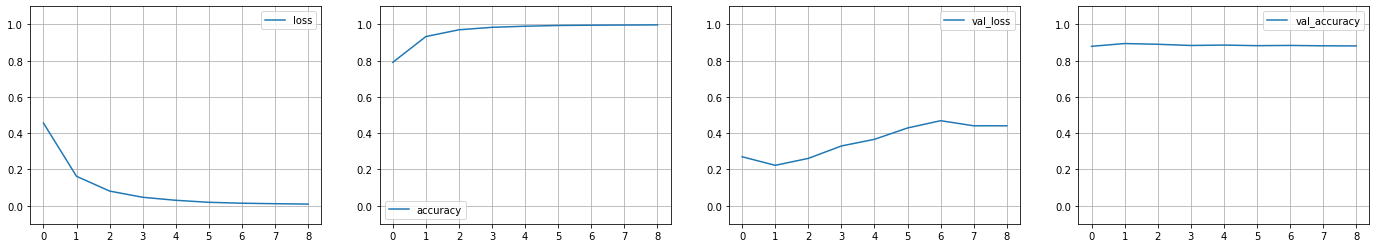

In [65]:
from matplotlib import pyplot as plt

k = hist.history.keys()

w,h = 6,4

fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
for i,n in enumerate(k):
    ax[i].plot(hist.history[n],label=n)
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_ylim([-.1,1.1])